In [2]:
import numpy as np
from scipy.io.wavfile import read
import wave
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import resample_poly

In [4]:
noaa_data = "../live_output/2024-06-28_18-42_noaa_apt_137.1 MHz/2024-06-28_18-44-46_1500000SPS_137100000Hz.wav"

wav_file = wave.open('../live_output/2024-06-28_18-42_noaa_apt_137.1 MHz/2024-06-28_18-44-46_1500000SPS_137100000Hz.wav', 'rb')

Fs, data = read(noaa_data)

print('Sampling rate {} Hz'.format(Fs))
print('Data type {} '.format(data.dtype))
params = wav_file.getparams()
print(params)

Sampling rate 1500000 Hz
Data type int16 
_wave_params(nchannels=2, sampwidth=2, framerate=1500000, nframes=263782400, comptype='NONE', compname='not compressed')


In [5]:
#kanał 0 to I, kanał 1 to Q
I = data[:, 0]
Q = data[:, 1]

In [7]:
#usunięcie DC offset 
I_centered = I - np.mean(I)
Q_centered = Q - np.mean(Q)

In [8]:
#normalizacja sygnału, każda próbka jest dzielona przez maksymalną wartość, aby wartości sygnału mieściły się w przedziale -1,1
I_centered = I_centered.astype(np.float32) / np.iinfo(np.int16).max
Q_centered = Q_centered.astype(np.float32) / np.iinfo(np.int16).max

In [9]:
IQ = I_centered + 1j * Q_centered

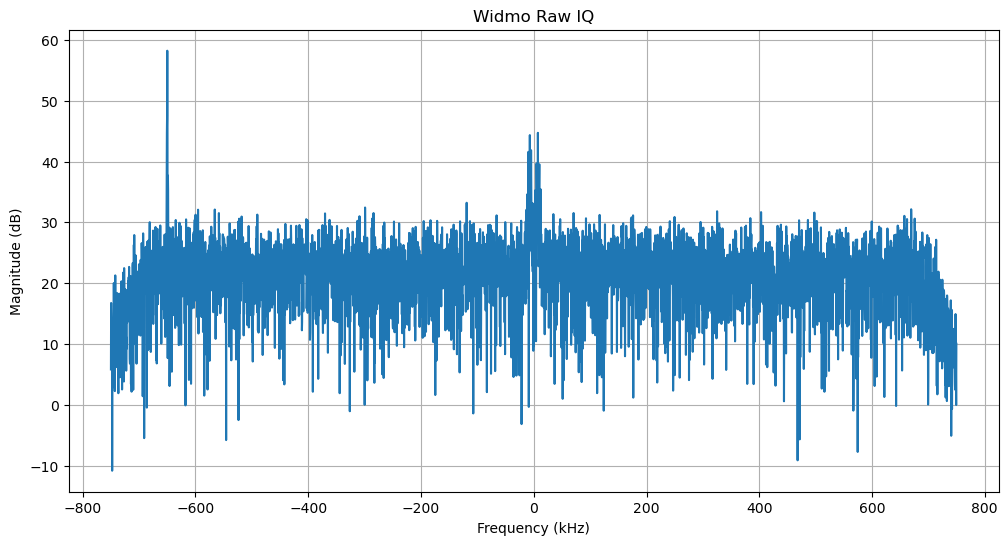

In [14]:
fft_size = 4096

IQ_fft = fftshift(fft(IQ, n=fft_size))
freqs = fftshift(fftfreq(fft_size, d=1/Fs))

plt.figure(figsize=(12, 6))
plt.plot(freqs / 1e3, 20 * np.log10(np.abs(IQ_fft)))
plt.title('Widmo Raw IQ')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.show()

In [ ]:
from scipy.signal import butter, filtfilt

# Parametry filtra
cutoff = 20e3  # deviacja 17 kHz + 3k zapasu
nyq_rate = Fs / 2.0
order = 5

# Zaprojektowanie filtru dolnoprzepustowego Butterwortha (o płaskiej charakterystyce amplitudowej filtr nie zniekształci sygnału)
b, a = butter(order, cutoff / nyq_rate, btype='low')

# Podwójna filtracja sygnału, aby nie wstąpiły przesunięcia fazy
IQ_filtered = filtfilt(b, a, IQ)


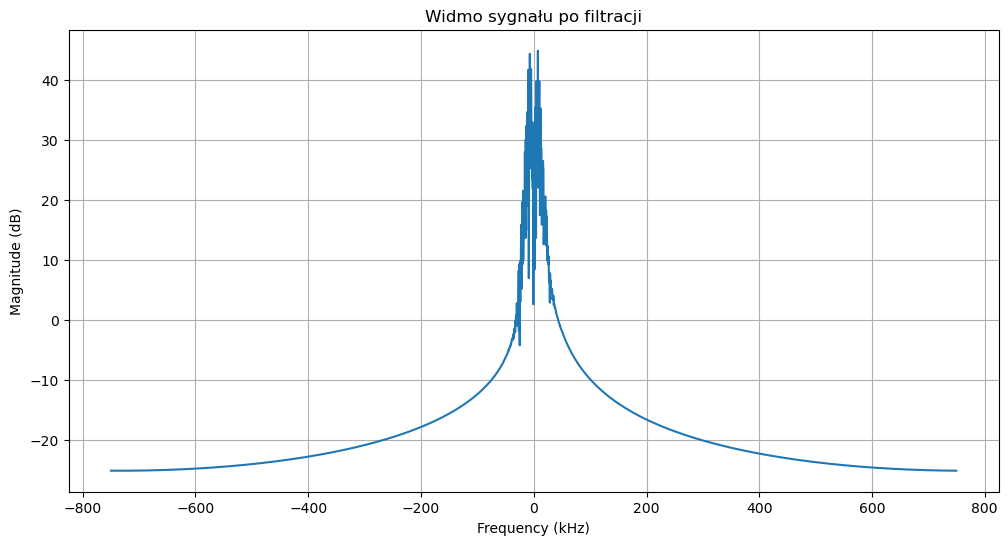

In [18]:
IQ_filtered_fft = fftshift(fft(IQ_filtered, n=fft_size))

plt.figure(figsize=(12, 6))
plt.plot(freqs / 1e3, 20 * np.log10(np.abs(IQ_filtered_fft)))
plt.title('Widmo sygnału po filtracji')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.show()

In [ ]:
# Obliczenie fazy sygnału
demodulated = np.angle(IQ_filtered[1:] * np.conj(IQ_filtered[:-1]))
#Każda próbka sygnału zespolonego jest mnożona przez sprzężenie zespolone poprzedniej próbki, iloczyn to rożnica faz między kolejnymi próbkami

K = Fs / (2 * np.pi * 17e3)
demodulated *= K
#zdemodulowany sygnał skaluję z rad na Hz, za pomocą stałej K

# Dodanie zera na początku, aby zachować długość sygnału, bo sygnał przez obliczanie różnicy faz jest o jedną próbkę krótszy
demodulated = np.insert(demodulated, 0, 0)

# Usunięcie offsetu DC
#demodulated -= np.mean(demodulated)

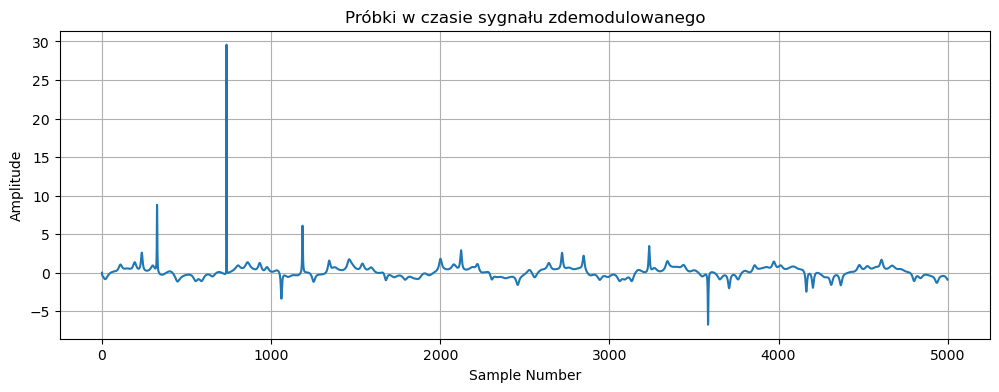

In [27]:
plt.figure(figsize=(12, 4))
plt.plot(demodulated[:5000])
plt.title('Próbki w czasie sygnału zdemodulowanego')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

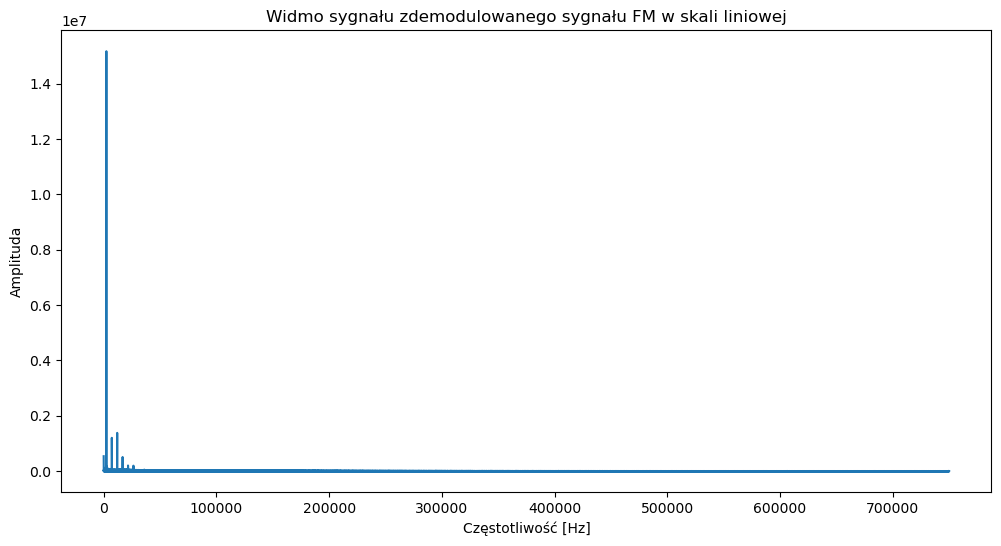

In [24]:
from scipy.fft import fft, fftfreq

N = len(demodulated)
yf = fft(demodulated)
xf = fftfreq(N, 1 / Fs)
plt.figure(figsize=(12, 6))
plt.plot(xf[0:N//2], np.abs(yf[0:N//2]))
plt.title('Widmo sygnału zdemodulowanego sygnału FM w skali liniowej')
plt.xlabel('Częstotliwość [Hz]')
plt.ylabel('Amplituda')
#plt.xlim(0, 5000)
plt.show()

In [ ]:
Fs_new = 11025
demodulated_resampled = resample_poly(demodulated, Fs_new, Fs)
Fs = Fs_new

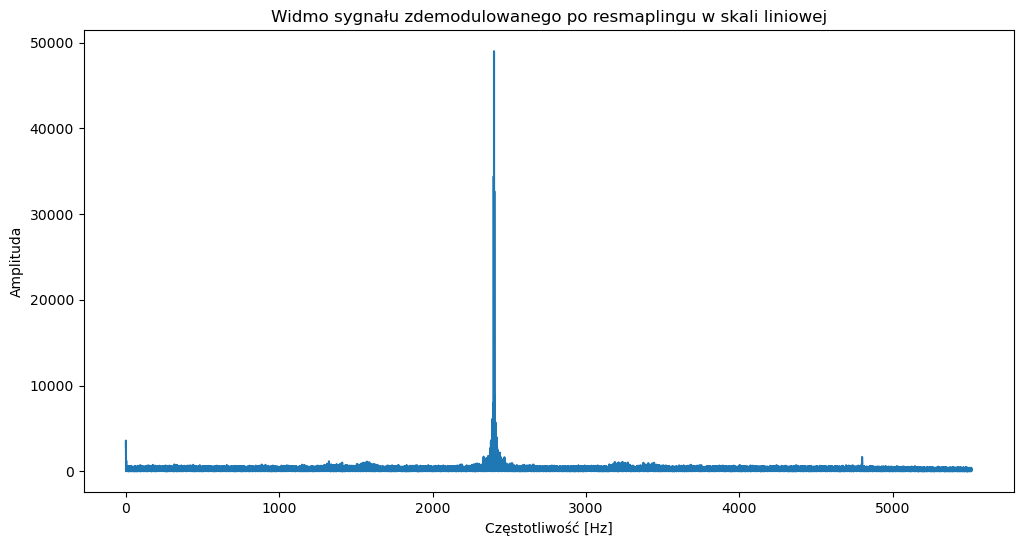

In [44]:
N = len(demodulated_resampled)
yf = fft(demodulated_resampled)
xf = fftfreq(N, 1 / Fs)
plt.figure(figsize=(12, 6))
plt.plot(xf[0:N//2], np.abs(yf[0:N//2]))
plt.title('Widmo sygnału zdemodulowanego po resmaplingu w skali liniowej')
plt.xlabel('Częstotliwość [Hz]')
plt.ylabel('Amplituda')
plt.show()

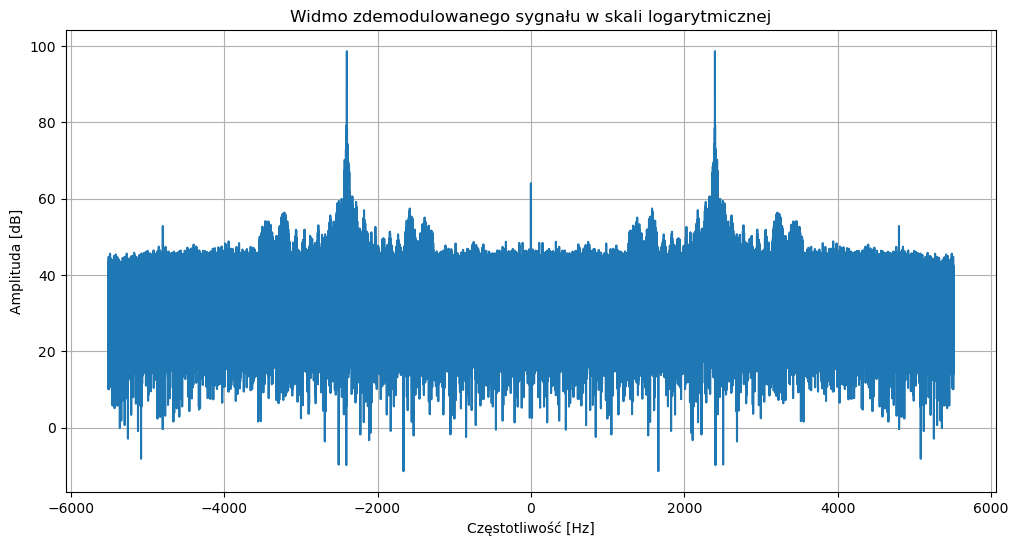

In [30]:
from scipy.fft import fft, fftfreq, fftshift
fft_size = 2**18 #262144
demod_fft = np.fft.fftshift(np.fft.fft(demodulated_resampled, n=fft_size))
freqs = np.fft.fftshift(np.fft.fftfreq(fft_size, d=1/Fs))

plt.figure(figsize=(12, 6))
plt.plot(freqs, 20 * np.log10(np.abs(demod_fft)))
plt.title('Widmo zdemodulowanego sygnału w skali logarytmicznej')
plt.xlabel('Częstotliwość [Hz]')
plt.ylabel('Amplituda [dB]')
plt.grid(True)
plt.show()

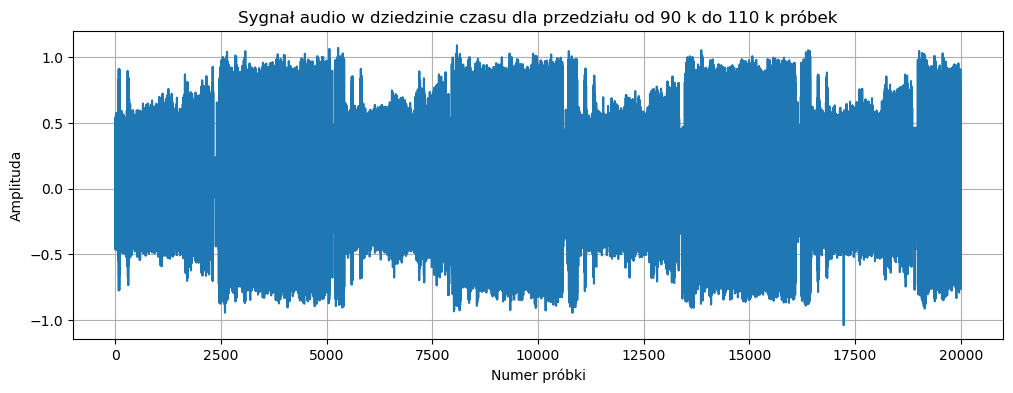

In [52]:
plt.figure(figsize=(12, 4))
plt.plot(demodulated_resampled[90000:110000])
plt.title('Sygnał audio w dziedzinie czasu dla przedziału od 90 k do 110 k próbek')
plt.xlabel('Numer próbki')
plt.ylabel('Amplituda')
plt.grid(True)
plt.show()

In [ ]:
from scipy.io.wavfile import write

# Normalizacja sygnału i konwersja na typ danych 16bit (32767 max watość dodatnia dla typu int16)
demodulated_resampled /= np.max(np.abs(demodulated_resampled))
demodulated_resampled_int16 = (demodulated_resampled * 32767).astype(np.int16)

# Zapis do pliku wav
write('../live_output/2024-06-28_18-42_noaa_apt_137.1 MHz/LO_demodulated.wav', Fs, demodulated_resampled_int16)